In [1]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

In [2]:
from sklearn.metrics import classification_report

In [3]:
import pandas as pd
df=pd.read_csv("source_Xqingxu.csv",encoding="utf-8")

df=df.dropna(axis=0)


In [4]:
df.shape

(8000, 5)

In [5]:
dfnew=pd.read_csv("source_y.csv",encoding="utf-8")

df=pd.concat([df,dfnew],axis=1)

df["happiness"].value_counts()

df["happiness"]=df["happiness"].map({1:0,2:1,3:2,4:3,5:4})
df=pd.concat([df[df["happiness"]==3].sample(frac=0.3),df[df["happiness"]!=3]],axis=0)
label=df["happiness"]
df["newcol_1"]=1
df["newcol_2"]=0
del df["happiness"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.2, random_state=42)

In [6]:
col=[]
for i in df.columns:
    col.append(i.split("_")[0])

import numpy as np
l=[]
first=0
last=0
colname=[]
for ind,i in enumerate(col):
    last+=1
    if last==len(col):
         
         print (df[df.columns[first:last]])
         colname.append(df.columns[first:last][0][:-2])
         l.append(np.argmax(df[df.columns[first:last]].values,axis=1))
         break
    if col[last]!=col[last-1]:
         print (df[df.columns[first:last]])
         colname.append(df.columns[first:last][0][:-2])
#          print (np.argmax(df[df.columns[first:last]].values,axis=1).max())
         l.append(np.argmax(df[df.columns[first:last]].values,axis=1))
         first=last
         last=last+1
         
#          break

      depression_1  depression_2  depression_3  depression_4  depression_5
2108             0             0             0             1             0
6802             0             0             0             1             0
5521             0             0             0             1             0
6590             0             0             0             0             1
1312             0             1             0             0             0
...            ...           ...           ...           ...           ...
7987             0             0             1             0             0
7992             0             0             0             0             1
7995             0             0             1             0             0
7996             0             0             1             0             0
7998             0             0             0             1             0

[4627 rows x 5 columns]
      newcol_1  newcol_2
2108         1         0
6802         1         0


In [7]:
colname

['depression', 'newcol']

In [9]:
import pandas as pd

dfemd=pd.DataFrame()

embed_num=[]
for ind,i in enumerate(l):
    dfemd[ind]=i
    embed_num.append(len(dfemd[ind].unique())+2)

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import *
import numpy as np
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, Dropout, Bidirectional

from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import re
from tensorflow.keras.callbacks import Callback
import tensorflow
from tensorflow.keras.models import load_model
from sklearn import metrics
from sklearn.model_selection import KFold


def get_deep_wide_net():
    embedall=[]
    for ind,i in enumerate(dfemd.columns):
         embedall.append(Embedding(100, 128, input_length=1,
                      trainable=True))

    len(embedall)

    input1 = Input(shape=(X_train.shape[1], )) #模型的入口,设置输入的维度
    embedl=[]
    for i in range(len(embedall)):
        embedl.append(Input(shape=(1,)))

    l=[]
    for i in range(len(embedl)):
        l.append(embedall[i](embedl[i]))

    embedcat=Concatenate()(l)

    embedcat=Dense(128,activation="relu")(embedcat)

    floatdense=Dense(128)(input1)
    embedcatnew=Flatten()(embedcat)

    last=Concatenate()([embedcatnew,floatdense])
    output1=Dense(128)(last)
    output = Dense(5, activation='softmax')(output1)#softmax层

    model = Model(inputs=[input1]+embedl, outputs=output)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])#定义损失函数，优化器，评分标准
    model.summary()
    return model

In [10]:
from sklearn import metrics
recal_all=[]
pre_all=[]
f1_all=[]
acc_all=[]
f1_micro=[]

t_recal_all=[]
t_pre_all=[]
t_f1_all=[]
t_acc_all=[]
t_f1_micro=[]
k=5
kf = KFold(n_splits=k, shuffle=True)
#     tmppre=np.zeros(y.shape)
ind=0
for (train, test) in  kf.split(df.values):
        print ("fold",ind,"start")
        X_train=df.values[train]
        y_train=label.values[train]
        emd_train=dfemd.values[train]
        emd_test=dfemd.values[test]
        train_all=[]
        train_all.append(X_train)
        for ind in range(emd_train.shape[1]):
            train_all.append(np.expand_dims(emd_train[:,ind],axis=1))
            
       
        X_test=df.values[test]
        testall=[]
        testall.append(X_test)
        for ind in range(emd_test.shape[1]):
            testall.append(np.expand_dims(emd_test[:,ind],axis=1))
#         break
        y_test=label.values[test]
        X_train=X_train.reshape(X_train.shape[0],X_train.shape[1])
        X_test=X_test.reshape(X_test.shape[0],X_test.shape[1])
        
        callbacks = [EarlyStopping(monitor='val_acc', verbose=1, patience=1000),
             ModelCheckpoint("model_wide_class_{}.hdf5".format(ind), monitor='val_acc',
                             mode='max', verbose=0, save_best_only=True,save_weights_only=True)]
        model_new = get_deep_wide_net()

        model_new.fit(train_all, y_train, epochs=20, batch_size=16, validation_data=(testall, y_test) ,callbacks=callbacks)
        model_new.load_weights("model_wide_class_{}.hdf5".format(ind)) #加载最优模型
        ypre=np.argmax(model_new.predict(testall),axis=-1)
        tmpacc=accuracy_score(y_test,ypre)
        tmppre=precision_score(y_test,ypre,average="macro")
        tmprecal=recall_score(y_test,ypre,average="macro")
        tmpf1=f1_score(y_test,ypre,average="macro")
        tmpf1_mic=f1_score(y_test,ypre,average="micro")
        print ("fold_{} acc: {} precision: {} recall : {} ,mac f1: {} ,mic f1: {}".format(ind,tmpacc,tmppre,tmprecal,tmpf1,tmpf1_mic))
        print ("test reprot: ",classification_report(y_test,ypre,digits=4))
        recal_all.append(tmprecal)
        acc_all.append(tmpacc)
        f1_all.append(tmpf1)
        pre_all.append(tmppre)
        f1_micro.append(tmpf1_mic)
        ind+=1

        ypre=np.argmax(model_new.predict(train_all),axis=-1)
        tmpacc=accuracy_score(y_train,ypre)
        tmppre=precision_score(y_train,ypre,average="macro")
        tmprecal=recall_score(y_train,ypre,average="macro")
        tmpf1=f1_score(y_train,ypre,average="macro")
        tmpf1_mic=f1_score(y_train,ypre,average="micro")
        print ("fold_{} train_acc: {} train_precision: {} train_recall : {},mac f1: {} ,mic f1: {}".format(ind,tmpacc,tmppre,tmprecal,tmpf1,tmpf1_mic))
        print ("train reprot: ",classification_report(y_train,ypre,digits=4))
        t_recal_all.append(tmprecal)
        t_acc_all.append(tmpacc)
        t_f1_all.append(tmpf1)
        t_pre_all.append(tmppre)
        t_f1_micro.append(tmpf1_mic)
    
print ("max acc:{}".format(max(acc_all)))
print ("min acc:{}".format(min(acc_all)))
print ("mean acc:{}".format(sum(acc_all)/5))


print ("max precision:{}".format(max(pre_all)))
print ("min precision:{}".format(min(pre_all)))
print ("mean precision:{}".format(sum(pre_all)/5))

print ("max recall:{}".format(max(recal_all)))
print ("min recall:{}".format(min(recal_all)))
print ("mean recall:{}".format(sum(recal_all)/5))



print ("max mac f1:{}".format(max(f1_all)))
print ("min mac f1:{}".format(min(f1_all)))
print ("mean mac f1:{}".format(sum(f1_all)/5))

print ("max mic f1:{}".format(max(f1_micro)))
print ("min mic f1:{}".format(min(f1_micro)))
print ("mean mic f1:{}".format(sum(f1_micro)/5))


print ("train max acc:{}".format(max(t_acc_all)))
print ("train min acc:{}".format(min(t_acc_all)))
print ("train mean acc:{}".format(sum(t_acc_all)/5))



print ("train max precision:{}".format(max(t_pre_all)))
print ("train min precision:{}".format(min(t_pre_all)))
print ("train mean precision:{}".format(sum(t_pre_all)/5))


print ("train max recall:{}".format(max(t_recal_all)))
print ("train min recall:{}".format(min(t_recal_all)))
print ("train mean recall:{}".format(sum(t_recal_all)/5))


print ("train max mac f1:{}".format(max(t_f1_all)))
print ("train min mac f1:{}".format(min(t_f1_all)))
print ("train mean mac f1:{}".format(sum(t_f1_all)/5))


print ("train max mic f1:{}".format(max(t_f1_micro)))
print ("train min mic f1:{}".format(min(t_f1_micro)))
print ("train mean mic f1:{}".format(sum(t_f1_micro)/5))

fold 0 start
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 128)       12800       input_2[0][0]                    
___________________________________________

/Users/kongmiao/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kongmiao/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kongmiao/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kongmiao/opt/ana

fold_1 acc: 0.40928725701943847 precision: 0.25016415762456523 recall : 0.2824699781866985 ,mac f1: 0.26240481130828874 ,mic f1: 0.40928725701943847
test reprot:                precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        18
           1     0.0000    0.0000    0.0000       103
           2     0.3407    0.4779    0.3978       226
           3     0.4060    0.5034    0.4495       296
           4     0.5041    0.4311    0.4648       283

    accuracy                         0.4093       926
   macro avg     0.2502    0.2825    0.2624       926
weighted avg     0.3670    0.4093    0.3828       926

fold_2 train_acc: 0.40934882464198863 train_precision: 0.25084296447775234 train_recall : 0.2830261704964525,mac f1: 0.26325712517722827 ,mic f1: 0.40934882464198863
train reprot:                precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        86
           1     0.0000    0.0000    0.0000       394
    

/Users/kongmiao/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kongmiao/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kongmiao/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kongmiao/opt/ana

train reprot:                precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        89
           1     0.2793    0.2706    0.2749       388
           2     0.3680    0.3808    0.3743       956
           3     0.3938    0.4816    0.4333      1140
           4     0.5096    0.4255    0.4638      1128

    accuracy                         0.4048      3701
   macro avg     0.3101    0.3117    0.3092      3701
weighted avg     0.4010    0.4048    0.4003      3701

fold 2 start
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 1)]          0                

/Users/kongmiao/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kongmiao/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kongmiao/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kongmiao/opt/ana

fold_2 train_acc: 0.4105888708806051 train_precision: 0.25128098919898034 train_recall : 0.2832283521239334,mac f1: 0.26335905406782023 ,mic f1: 0.4105888708806051
train reprot:                precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        78
           1     0.0000    0.0000    0.0000       399
           2     0.3430    0.4881    0.4029       924
           3     0.4093    0.4953    0.4482      1171
           4     0.5041    0.4327    0.4657      1130

    accuracy                         0.4106      3702
   macro avg     0.2513    0.2832    0.2634      3702
weighted avg     0.3690    0.4106    0.3845      3702

fold 2 start
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1)]          0                                            
_____

/Users/kongmiao/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kongmiao/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kongmiao/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kongmiao/opt/ana

fold_1 acc: 0.40864864864864864 precision: 0.32227199109221577 recall : 0.3195956404938588 ,mac f1: 0.3182795677542932 ,mic f1: 0.40864864864864864
test reprot:                precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        22
           1     0.3333    0.3043    0.3182        92
           2     0.3895    0.4211    0.4047       247
           3     0.3750    0.4698    0.4171       281
           4     0.5135    0.4028    0.4515       283

    accuracy                         0.4086       925
   macro avg     0.3223    0.3196    0.3183       925
weighted avg     0.4082    0.4086    0.4045       925

fold_2 train_acc: 0.4081577525661804 train_precision: 0.30996871190896474 train_recall : 0.3068052404094324,mac f1: 0.3063561220885715 ,mic f1: 0.4081577525661804
train reprot:                precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        82
           1     0.2880    0.2198    0.2493       405
        

/Users/kongmiao/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kongmiao/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kongmiao/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kongmiao/opt/ana

In [11]:
import random

In [12]:
#model_new.load_weights("model_wide_class_{}.hdf5".format(ind))

In [13]:
from tqdm import tqdm
def get_important(col="gender",M=100,I=100):
    
    sumall=[]
    for num in tqdm(range(I)):
        num_fea=colname.index(col)+1
        for i in random.sample(list(range(len(train_all))),1):  # (1)随机采样一条样本xi
        #     print (i)
            xi=[]
            for j in range(len(train_all)):
                xi.append(train_all[j][i:i+1])
        tmp1=[]
        for i in range(M):
            for i in random.sample(list(range(len(train_all))),1): #(2)随机采样一条样本z
        #         print (i)
                z=[]
                for j in range(len(train_all)):
                    z.append(train_all[j][i:i+1])
            shutuf=random.sample(list(range(len(colname))),len(colname)) #(3)随机采样1到n排列 

            x_=[xi[0]]+list(np.array(xi[1:])[shutuf])#（4）
            z_=[z[0]]+list(np.array(z[1:])[shutuf])#(5)

            x_1=x_[:1+num_fea]+z_[1+num_fea:]
            x_2=x_[:num_fea]+z_[num_fea:] #(6)

        #     print (abs(np.mean(model_new.predict(x_1)-model_new.predict(x_2),axis=1)[0])) #(7)
            tmp1.append(abs(model_new.predict(x_1)-model_new.predict(x_2)))
        sumall.append(tmp1)
    return np.mean(np.array(sumall),axis=0)[0]

In [14]:
fea_import=[]
for col in colname:
    tmp=get_important(col,M=40,I=40)
    fea_import.append(tmp)

100%|██████████| 40/40 [00:05<00:00,  7.50it/s]


In [15]:
dfnew=pd.DataFrame(np.squeeze(np.array(fea_import)))
dfnew.columns=[str(i)+"_Importance" for  i in [1,2,3,4,5]]

In [16]:
dfnew.index=colname

In [17]:
dfnew=dfnew[:-1]

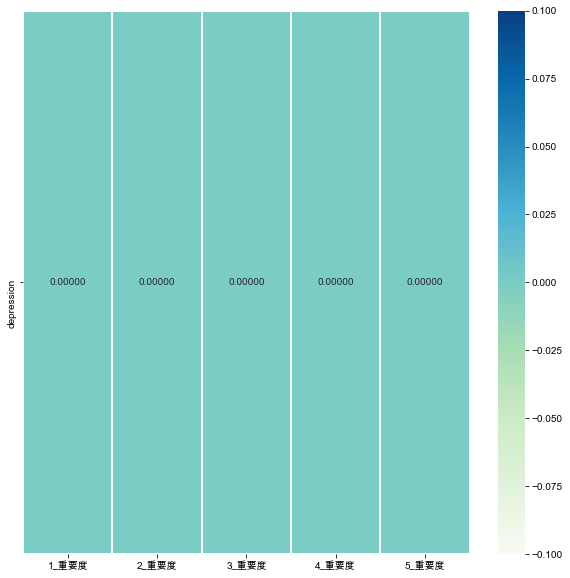

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(10,10))
sns.heatmap(data=dfnew,linewidths=1,annot=True,cmap="GnBu",fmt=".5f")
plt.savefig("2.9宽深-value情绪.png",dpi=300)

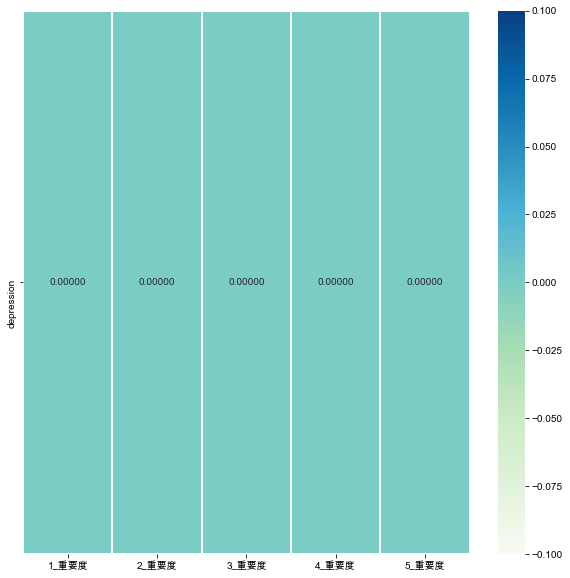

In [19]:
dfnew=dfnew.sort_values(by="3_Importance",ascending=False)
dfnew=dfnew[:10]
plt.figure(figsize=(10,10))
sns.heatmap(data=dfnew,linewidths=1,annot=True,cmap="GnBu",fmt=".5f")
plt.savefig("2.9宽深value_排序前10个情绪.png",dpi=300)

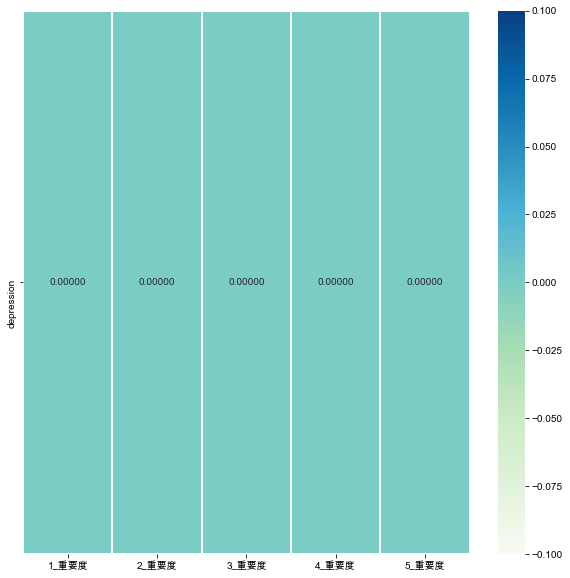

In [20]:
dfnew=dfnew.sort_values(by="3_Importance",ascending=False)
dfnew=dfnew[:10]
plt.figure(figsize=(10,10))
sns.heatmap(data=dfnew,linewidths=1,annot=True,cmap="GnBu",fmt=".5f")
plt.savefig("2.9宽深value_排序前10个情绪.pdf",dpi=300)

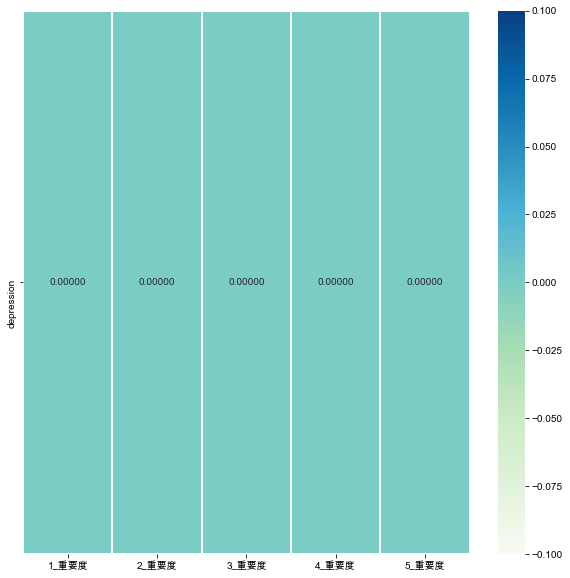

In [21]:
dfnew=dfnew.sort_values(by="3_Importance",ascending=False)
dfnew=dfnew[:5]
plt.figure(figsize=(10,10))
sns.heatmap(data=dfnew,linewidths=1,annot=True,cmap="GnBu",fmt=".5f")
plt.savefig("2.9宽深value_排序前5个情绪.png",dpi=300)

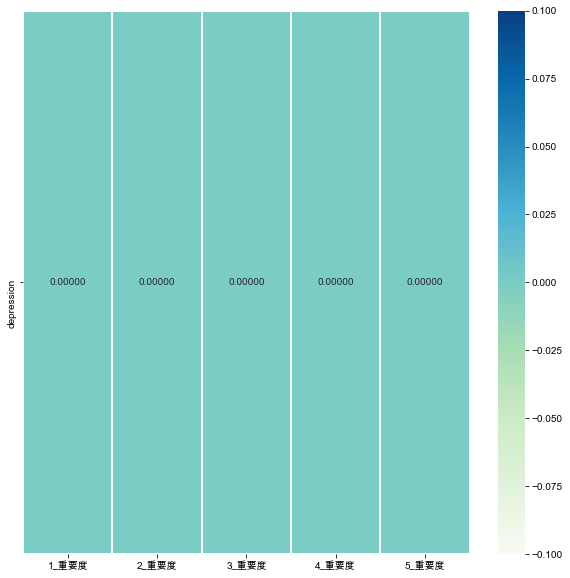

In [22]:
dfnew=dfnew.sort_values(by="3_Importance",ascending=False)
dfnew=dfnew[:5]
plt.figure(figsize=(10,10))
sns.heatmap(data=dfnew,linewidths=1,annot=True,cmap="GnBu",fmt=".5f")
plt.savefig("2.9宽深value_排序前5个情绪.pdf",dpi=300)